In [277]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

In [278]:
data = datasets.load_iris()
print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [279]:
X_norm = data['data'][:,[2,3]]
y_norm = data['target']

In [280]:
def one_hot_encode(y):
    n_classes = len(np.unique(y))
    one_hot_y = np.zeros((len(y),n_classes))
    one_hot_y[np.arange(len(y)),y] = 1 #since y = 0,1,2, this determines the column to set it to 1 (true). else is 0 (false)
    
    return one_hot_y    

Transform the target to a one-hot encoded vector.

Append to the training data the bias term.

In [281]:
y = one_hot_encode(y_norm)
print(y_norm[0:10])
print(y[0:10])

X = np.c_[np.ones([len(X_norm),1]), X_norm]
print(X.shape)
print(X_norm.shape)

[0 0 0 0 0 0 0 0 0 0]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(150, 3)
(150, 2)


In [282]:
#Function to split the dataset into 3 parts randomly.
def my_split_func(X,y,test_size = .2, val_size = .2):
    m = len(X)    

    np.random.seed(42)     
    indx = np.arange(0,m)
    np.random.shuffle(indx)
    
    indx_train= indx[0:int(m*(1-test_size - val_size))]
    indx_test = indx[int(m*(1-test_size - val_size)):int(m*(1-val_size))]
    indx_val =  indx[int(m*(1 - val_size)): m]
    
    X_train, y_train = X[indx_train,:] , y[indx_train,:]
    X_test, y_test = X[indx_test,:] , y[indx_test,:]
    X_val, y_val = X[indx_val,:] , y[indx_val,:]
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [283]:
def softmax(score_x):
    score_x_rel = score_x - np.max(score_x,axis=1).reshape(-1,1) #to avoid overflow, remove the maximum probability
    
    numer = np.exp(score_x_rel)
    denom = np.sum(np.exp(score_x_rel), axis = 1, keepdims= True)
    return numer / denom
    

def my_predict(X,params,return_probas = False):
    score = X.dot(params)
    probas = softmax(score) 
    if return_probas:
        return probas #if we want probabilities instead of predictions
    else:
        return np.argmax(probas,axis=1)
    

def cross_entropy_gradients(y,p_x,X):
    diff = p_x - y
    
    grads = 1/len(p_x) * X.T.dot(diff)
        
    return grads

def my_cost_function(p_x,y):
    epsilon = 1e-6 #small addition to prevent log10(0)
    return -np.mean(np.sum(y*np.log10(p_x+epsilon),axis=1)) #estimate the cost for these parameters

Iteration 0, training cost 2.37546352405998
Iteration 500, training cost 0.2701650249654864
Iteration 1000, training cost 0.2669751426623931
Iteration 1500, training cost 0.266737947927817
Iteration 2000, training cost 0.26671693997376844
Iteration 2500, training cost 0.2667150453645324
Iteration 3000, training cost 0.26671487420239853
Iteration 3500, training cost 0.26671485873676376
Iteration 4000, training cost 0.26671485733931866
Iteration 4500, training cost 0.26671485721304794
Iteration 5000, training cost 0.2667148572016383
Iteration 5500, training cost 0.26671485720060745
Stopping at iteration 5788!


C:\Users\Gerardo\AppData\Local\Temp\ipykernel_10656\1566677742.py:54: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = my_predict(X_val,params = best_params) == y_val;


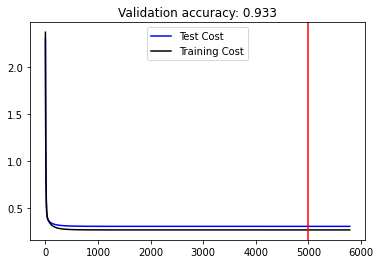

In [285]:
#hyper parameters
lr = .1
alpha = .7
num_iters = 10000



n_classes = len(np.unique(y_norm))
n_features = X.shape[1]
theta = np.random.random((n_features,n_classes)) #3 features, 3 classes

min_cost = float("inf")
best_params = []
train_costs,val_costs,test_costs = [],[],[]

X_train, X_test, X_val, y_train, y_test, y_val = my_split_func(X,y,test_size = .1)
for k in range(0,num_iters):


    #Fit model and estimate gradients
    scores_preds = X_train @ theta
    p_preds = softmax(scores_preds) #identify the probabilities for each class based on the scores
    gradients = cross_entropy_gradients(y_train,p_preds,X_train) #obtain gradients for this level
    regularization = np.r_[np.zeros((1,n_features)), alpha *theta[1:,:]]

    #Update parameters
    theta = lr * -( gradients + regularization) + theta #update the parameters by the gradient
    
    
    ## Analyze cost on the training dataset
    this_train_cost = my_cost_function(p_preds,y_train) +  alpha/2 * np.sum(theta[1:,:]) ** 2 #cost has the l2 penalty, do not apply to bias term
    train_costs.append(this_train_cost)
    
    
    ## Analyze cost on the testing dataset
    scores_test = X_test @ theta
    p_test = softmax(scores_test) #extract the probabilities for the test set
    this_test_cost = my_cost_function(p_test,y_test) +  alpha/2 * np.sum(theta[1:,:]) ** 2 #cosst has the l2 penalty
    
    test_costs.append(this_test_cost)
    if this_test_cost < min_cost:
        min_cost = this_test_cost
        best_params = theta
    else:
        print(f'Stopping at iteration {k}!')
        num_iters = k+1
        break
           
    #Status update
    if np.mod(k,500) == 0:
        print(f'Iteration {k}, training cost {this_train_cost}')
        
    
accuracy = my_predict(X_val,params = best_params) == y_val;
        
plt.plot(range(0,num_iters),test_costs,color = 'blue',label = 'Test Cost')
plt.plot(range(0,num_iters),train_costs,color = 'black',label = 'Training Cost')
plt.legend()
plt.axvline(good_iter,color = 'red')
plt.title('Validation accuracy: ' + str(np.round(np.mean(one_hot_encode(my_predict(X_val,best_params)) == y_val),3))); 